In [10]:
import os
import sys
import pandas
import numpy, scipy, sklearn

import findspark
findspark.init("/usr/local/spark/spark")

import pyspark
from pyspark.sql.window import Window
import pyspark.sql.functions as func

from pyspark.rdd import reduce
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
import pyspark.mllib.linalg.distributed
from pyspark.mllib.linalg.distributed import RowMatrix, DenseMatrix
from pyspark.ml.linalg import SparseVector, VectorUDT, Vector, Vectors
from pyspark.mllib.stat import Statistics

In [54]:


import sklearn
import math
import numpy
from numpy import matmul
import scipy
from scipy import linalg
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles

%matplotlib inline  
import matplotlib.pyplot as plt



In [2]:
file_name = "/Users/simondi/PROJECTS/target_infect_x_project/src/tix-analysis/data/single_cell_samples.tsv"

In [3]:
conf = pyspark.SparkConf().setMaster("local[*]").set("spark.driver.memory", "4G").set("spark.executor.memory", "4G")
sc = pyspark.SparkContext(conf=conf)
spark = pyspark.sql.SparkSession(sc)

In [4]:
spark.version

'2.3.0'

In [4]:
df = spark.read.csv(path=file_name, sep="\t", header='true')

In [5]:
old_cols = df.columns
new_cols = list(map(lambda x: x.replace(".", "_"), old_cols))

df = reduce(
  lambda data, idx: data.withColumnRenamed(old_cols[idx], new_cols[idx]),
  range(len(new_cols)), df)

for i, x in enumerate(new_cols):
    if x.startswith("cells") or x.startswith("perin") or x.startswith("nucl"):
        df = df.withColumn(x, df[x].cast("double"))

df = df.fillna(0)

In [6]:
df.take(1)

[Row(study='infectx_published', pathogen='listeria', library='a', design='u', replicate='1', plate='kb2-02-1x', well='a01', gene='chka', sirna='s3008', well_type='sirna', image_idx='4', object_idx='144', cells_areashape_area=-0.8044235519947214, cells_areashape_eccentricity=0.01210726352227413, cells_areashape_extent=1.1159023326616404, cells_areashape_formfactor=1.4749286136850854, cells_areashape_majoraxislength=-0.9368530225439791, cells_areashape_minoraxislength=-0.7485320762193192, cells_areashape_perimeter=-1.0209269921587854, cells_children_bacteria_count=-0.7030171063989196, cells_children_invasomes_count=0.0, cells_location_center_x=0.44758084788204255, cells_location_center_y=1.2808903222918113, cells_neighbors_anglebetweenneighbors_2=1.3915760955745562, cells_neighbors_firstclosestobjectnumber_2=0.14886791955020456, cells_neighbors_firstclosestxvector_2=0.6694456185473984, cells_neighbors_firstclosestyvector_2=-1.233468444008488, cells_neighbors_numberofneighbors_2=-0.082518

In [30]:
data = df.toPandas()
fc = list(filter(lambda x: x.startswith("cells"), data.columns))
data = data[fc]
data[:5]

,cells_areashape_area,cells_areashape_eccentricity,cells_areashape_extent,cells_areashape_formfactor,cells_areashape_majoraxislength,cells_areashape_minoraxislength,cells_areashape_perimeter,cells_children_bacteria_count,cells_children_invasomes_count,cells_location_center_x,cells_location_center_y,cells_neighbors_anglebetweenneighbors_2,cells_neighbors_firstclosestobjectnumber_2,cells_neighbors_firstclosestxvector_2,cells_neighbors_firstclosestyvector_2,cells_neighbors_numberofneighbors_2,cells_neighbors_secondclosestobjectnumber_2,cells_neighbors_secondclosestxvector_2,cells_neighbors_secondclosestyvector_2,cells_parent_nuclei
0,-0.804424,0.012107,1.115902,1.474929,-0.936853,-0.748532,-1.020927,-0.703017,0.0,0.447581,1.280890,1.391576,0.148868,0.669446,-1.233468,-0.082518,0.010590,-0.507830,1.245537,0.135723
1,-0.947417,-0.039872,0.126236,0.619824,-1.008134,-0.795895,-0.948540,-0.632405,0.0,0.426316,-0.210378,-0.393921,0.394149,-0.378558,1.005330,-0.674801,0.267972,-1.062147,-0.589869,0.429000
2,-0.083864,1.123911,1.761118,0.848893,0.557173,-0.729131,-0.475111,0.497395,0.0,0.801443,-1.115465,0.699665,0.970561,-0.178526,1.066833,1.694328,1.101400,0.654194,-0.652910,0.942235
3,-0.313932,0.706511,-0.091321,0.843033,-0.105419,-0.558973,-0.598201,-0.067505,0.0,0.844086,0.163342,0.538777,0.896976,-0.284293,-1.291491,0.509764,0.991093,1.060553,0.745440,0.905576
4,-0.329909,-1.991598,1.681721,0.563054,-0.829567,0.350953,-0.528627,0.214945,0.0,1.166916,-0.347052,1.378619,1.326219,-0.318167,1.466327,1.694328,1.469089,0.423660,-1.182652,1.345491


In [31]:
data = data.values
data = data.astype(numpy.float64)
data[numpy.isnan(data)] = 0

In [32]:
# factor analysis
means = numpy.mean(data, axis=0)
std = numpy.nanstd(data, axis=0)
X = (data - means)

In [33]:
X.shape

(100, 20)

In [34]:
def rainbowfacet(x, y):
    psd = sklearn.metrics.pairwise.euclidean_distances(x, y) ** 2
    K = scipy.exp(- (1/x.shape[1]) * psd)
    return K

In [35]:
idx = numpy.random.choice(X.shape[0], 10, replace=False)

In [36]:
Xs = X[numpy.ix_(idx)]

In [37]:
def nystroem(X, m=5):
    idx = numpy.random.choice(X.shape[0], m, replace=False)    
    Xs = X[numpy.ix_(idx)]
    K_xs = rainbowfacet(X, Xs)
    K_ss = rainbowfacet(Xs, Xs)
    K_hat = K_xs.dot(numpy.linalg.pinv(K_ss)).dot(K_xs.T)
    return K_hat

In [48]:
def kernig(K):
    n, _ = K.shape
    O = numpy.ones(shape=(n, n)) / n
    Kt = K - numpy.matmul(O, K) - numpy.matmul(K, O) + numpy.matmul(O, numpy.matmul(K, O))
    return Kt

In [50]:
def kpca(K, n_components=2):
    U, L = scipy.linalg.eigh(K)
    indices = U.argsort()[::-1]
    U, L = U[indices], L[:, indices]
    L, U = L[:, U > 0], U[U > 0]
    return numpy.dot(K, (L / numpy.sqrt(U))[:, :n_components])

In [65]:
def fourier(X, n_features=10000):    
    w = numpy.random.normal(size=(X.shape[1], n_features))
    b = 2 * numpy.pi * numpy.random.rand(n_features)
    return numpy.sqrt(2.0 / n_features) * numpy.cos(numpy.dot(X, w) + b)

In [66]:
import sklearn.decomposition
import scipy
import scipy.linalg
import numpy

In [69]:
import sklearn.kernel_approximation

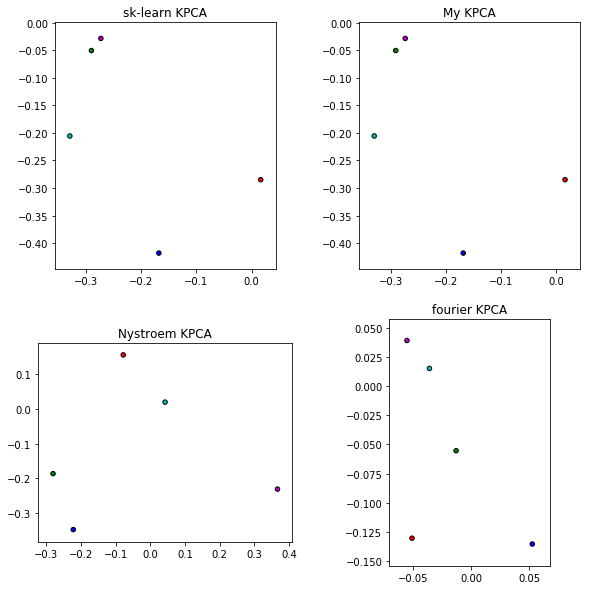

In [72]:
#Kf_pca = sklearn.decomposition.PCA(2).fit_transform(fourier(X, 2000))
#Kn_pca = kpca(kernig(nystroem(X, m=100)))
#K_pca = kpca(kernig(rainbowfacet(X, X)))
X_kpca = sklearn.decomposition.KernelPCA(2, kernel="rbf").fit_transform(X)
Kf_pca = sklearn.decomposition.PCA(2).fit_transform(fourier(X, 100))
Kn_pca = sklearn.decomposition.PCA(2).fit_transform(rbf_feature.fit_transform(X))
K_pca = kpca(kernig(rainbowfacet(X, X)))

colors = ["r", "b", "g", "c", "m", "y", "k", "w"]
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1, aspect='equal')
plt.scatter(X_kpca[:5, 0], X_kpca[:5, 1], c=(colors), s=20, edgecolor='k')
plt.title("sk-learn KPCA")

plt.subplot(2, 2, 2, aspect='equal')
plt.scatter(K_pca[:5, 0], K_pca[:5, 1], c=colors, s=20, edgecolor='k')
plt.title("My KPCA")

plt.subplot(2, 2, 3, aspect='equal')
plt.scatter(Kn_pca[:5, 0], Kn_pca[:5, 1], c=colors, s=20, edgecolor='k')
plt.title("Nystroem KPCA")

plt.subplot(2, 2, 4, aspect='equal')
plt.scatter(Kf_pca[:5, 0], Kf_pca[:5, 1], c=colors, s=20, edgecolor='k')
plt.title("fourier KPCA")


plt.show()

In [84]:
def fourier(X, n_features, seed, gamma):    
    random_state = numpy.random.RandomState(seed)
    w =  numpy.sqrt(2 * gamma) * random_state.normal(size=(X.shape[1], n_features))
    b = random_state.uniform(0, 2 * numpy.pi, size=n_features)
    return numpy.sqrt(2.0 / n_features) * numpy.cos(numpy.dot(X, w) + b)

In [86]:
rbf_feature = sklearn.kernel_approximation.RBFSampler(gamma=1, random_state=1)

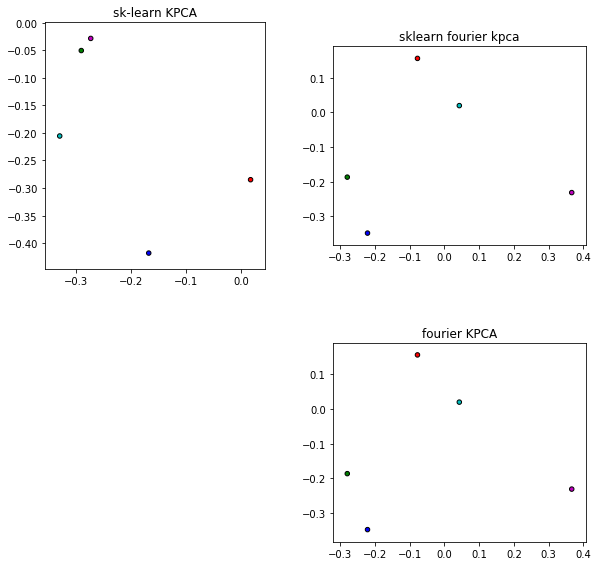

In [87]:
X_kpca = sklearn.decomposition.KernelPCA(2, kernel="rbf").fit_transform(X)
Kf_pca = sklearn.decomposition.PCA(2).fit_transform(fourier(X, 100, gamma=1, seed=1))
K_pca = sklearn.decomposition.PCA(2).fit_transform(rbf_feature.fit_transform(X))

colors = ["r", "b", "g", "c", "m", "y", "k", "w"]
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1, aspect='equal')
plt.scatter(X_kpca[:5, 0], X_kpca[:5, 1], c=(colors), s=20, edgecolor='k')
plt.title("sk-learn KPCA")

plt.subplot(2, 2, 2, aspect='equal')
plt.scatter(K_pca[:5, 0], K_pca[:5, 1], c=colors, s=20, edgecolor='k')
plt.title("sklearn fourier kpca")

plt.subplot(2, 2, 4, aspect='equal')
plt.scatter(Kf_pca[:5, 0], Kf_pca[:5, 1], c=colors, s=20, edgecolor='k')
plt.title("fourier KPCA")


plt.show()

In [91]:
feature_columns = [x for x in df.columns if x.startswith("cells")]
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
data = assembler.transform(df)

In [92]:
data

DataFrame[study: string, pathogen: string, library: string, design: string, replicate: string, plate: string, well: string, gene: string, sirna: string, well_type: string, image_idx: string, object_idx: string, cells_areashape_area: double, cells_areashape_eccentricity: double, cells_areashape_extent: double, cells_areashape_formfactor: double, cells_areashape_majoraxislength: double, cells_areashape_minoraxislength: double, cells_areashape_perimeter: double, cells_children_bacteria_count: double, cells_children_invasomes_count: double, cells_location_center_x: double, cells_location_center_y: double, cells_neighbors_anglebetweenneighbors_2: double, cells_neighbors_firstclosestobjectnumber_2: double, cells_neighbors_firstclosestxvector_2: double, cells_neighbors_firstclosestyvector_2: double, cells_neighbors_numberofneighbors_2: double, cells_neighbors_secondclosestobjectnumber_2: double, cells_neighbors_secondclosestxvector_2: double, cells_neighbors_secondclosestyvector_2: double, ce

In [93]:
rdd = data.select(feature_columns).rdd.map(numpy.array)
X = RowMatrix(rdd)

In [94]:
X = RowMatrix(X.rows.map(lambda x: x - means))

In [14]:
idx = numpy.random.choice(data.count(), 10, replace=False)

In [97]:
random_state = numpy.random.RandomState(1)

In [105]:
q = 100
gamma = 1

In [106]:
p = X.numCols()

In [107]:
w = numpy.sqrt(2 * gamma) * random_state.normal(size=(p, q))

In [109]:
w.shape

(20, 100)

In [111]:
b = random_state.uniform(0, 2 * numpy.pi, size=q)

In [112]:
b

array([5.52416748, 1.06060287, 4.42052077, 5.76331555, 0.94712521,
       1.53161424, 3.43492047, 2.16216556, 4.33941332, 0.36170801,
       1.0101109 , 4.500258  , 6.09857714, 5.84053727, 5.66157089,
       0.80263491, 0.91689843, 0.45405286, 3.40888082, 5.54482416,
       3.34134705, 4.911662  , 1.18409007, 5.42308799, 1.17762457,
       0.34409315, 2.64830612, 3.487824  , 6.09935193, 0.57650634,
       1.72107814, 0.66040719, 2.45320459, 1.81591019, 3.22516121,
       2.18816127, 5.83222865, 4.96338839, 5.40989398, 0.81367844,
       3.61327242, 1.34951847, 5.45530384, 0.09436981, 0.6644105 ,
       2.36283629, 2.52643052, 1.74182515, 0.60358162, 0.74600514,
       1.99770581, 5.97400757, 1.30317388, 4.69530073, 1.62224722,
       0.23398743, 0.100859  , 0.95947966, 2.90336061, 4.74946667,
       4.57927927, 2.21412817, 3.01052088, 5.11497625, 5.26784082,
       2.01009591, 0.0267979 , 0.29487518, 4.63578047, 1.71299914,
       3.02526458, 1.20656803, 5.32256743, 3.1628148 , 3.31224

In [ ]:
numpy.sqrt(2.0 / n_features) * numpy.cos(numpy.dot(X, w) + b)